# This notebook presents some variants from the standard pitch control

The code was adapted from Laurie Shawn, from FoT (https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)

A Pitch control is a graphical representation that helps us determine where to pass the ball in order to maintain the ball possession. Normally, the possession probability is computed for every field location, based on the ball and players positions and speeds.

However, in this work, the pitch control values don't actually represent the possession probability, but the **probability of implementing and put in practice the team game philosophy**.

In this work, 4 different variants of pitch control are presented:
- **Baseline:** Standard pitch control
- **Defensive approach:** The goal is to assure the ball possession retention, without performing risky passes
- **Attack approach - Vertical:** The goal is to assure the team gets close to the opponent goal, by performing passes in that direction
- **Attack approach - Flanks:** The goal is to make the team play to the flanks instead in playing through the middle

Some graphical comparisons between the different approaches are presented in the repository.

In [2]:
import LaurieOnTracking_SourceCode_adapted.Metrica_IO as mio
import LaurieOnTracking_SourceCode_adapted.Metrica_Viz as mviz
import LaurieOnTracking_SourceCode_adapted.Metrica_Velocities as mvel
import LaurieOnTracking_SourceCode_adapted.Metrica_PitchControl as mpc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import copy

In [5]:

DATADIR = '../tutorial_tracking_event_data/metrica_data'
game_id = 2

# EVENT DATA
events = mio.read_event_data(DATADIR,game_id)
events = mio.to_metric_coordinates(events)


# TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

Reading team: home
Reading team: away


In [6]:
def get_initial_pass(ind):
    
    team_event = events.loc[ind].Team
    counter = 0

    while team_event == events.loc[ind].Team:
        counter += 1
        team_event = events.loc[ind-counter].Team
        
    play = events.iloc[ind-counter:ind]
        
    return play[play['Type'].isin(['PASS', 'SHOT'])]

**Plot Pitch Control for the third Goal**

Third Goal Sequence:


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1284,Away,PASS,NaN,2,86935,3477.40,87003,3480.12,Player15,Player16,-14.84,-25.16,-23.32,-19.72
1285,Away,PASS,NaN,2,87035,3481.40,87077,3483.08,Player16,Player17,-23.32,-19.72,-29.68,0.00
1286,Away,PASS,NaN,2,87096,3483.84,87126,3485.04,Player17,Player18,-29.68,0.68,-22.26,20.40
1287,Away,PASS,NaN,2,87151,3486.04,87171,3486.84,Player18,Player20,-22.26,20.40,-20.14,10.20


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


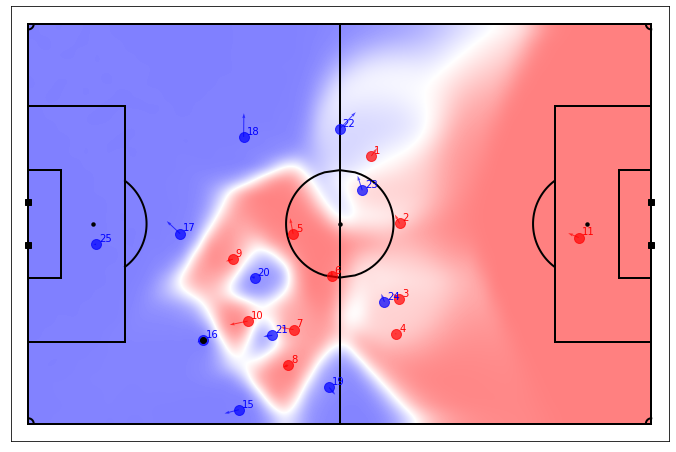

In [8]:
#code from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py

# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()


#THIRD GOAL
print('Third Goal Sequence:')
ind = goals.iloc[1].name
ind = events[events['Type']=='PASS'].sample(1, random_state = 20).iloc[0].name
third_goal = get_initial_pass(ind)

display(third_goal)
#mviz.plot_events( third_goal, color='k', indicators = ['Marker','Arrow'], annotate=True )


#PITCH CONTROL
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]


new_events = copy.deepcopy(events)
new_events[((new_events['Team'] == 'Home') & (new_events['Start Time [s]'] > 45*60)) |\
       ((new_events['Team'] == 'Away') & (new_events['Start Time [s]'] < 45*60))][['Start X', 'End X']] = -new_events[((new_events['Team'] == 'Home') & (new_events['Start Time [s]'] > 45*60)) |\
       ((new_events['Team'] == 'Away') & (new_events['Start Time [s]'] < 45*60))][['Start X', 'End X']]

def evaluate_actions(df):
    row_threshold = 2
    
    # sucess if there are at least 3 other actions, without 'LOST' on type or subtype, otherwise Unsucessfull
    for ind, row in df.iterrows():
        if (len(df) - 1) - ind >= row_threshold:
            next_df = df.iloc[ind+1:ind+row_threshold+1]

            if (next_df['Team'] == row['Team']).all() and not next_df['Type'].str.contains('LOST').any() and not next_df['Subtype'].str.contains('LOST').any():
                yield 1
            else:
                yield 0
        else:
            yield 0

new_events['status_actions'] = list(evaluate_actions(new_events))



# evaluated pitch control surface for specific pass
n_pass = 1
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(new_events, third_goal.iloc[n_pass].name, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, scenario='possession')
mviz.plot_pitchcontrol_for_event( third_goal.iloc[n_pass].name, events,  tracking_home, tracking_away, PPCF, annotate=True)


plt.show()